tickers: ['AAPL', 'ABBV', 'ADBE', 'AMD', 'AMZN', 'AVGO', 'BAC', 'BRK-B', 'COST', 'CRM', 'CVX', 'GOOG', 'HD', 'JNJ', 'JPM', 'KO', 'LLY', 'MA', 'META', 'MRK', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'TMO', 'TSLA', 'UNH', 'V', 'WMT', 'XOM']
time window = warmup-date: 2019-04-30, start-date: 2019-08-28, end-data: 2024-08-26


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

2019-08-28 BUY UNH because UNH Close (222.93,227.35) above Bollinger bottom (225.72) while RSI (33.09) below 44.00
2019-09-11 BUY ADBE because ADBE Close (276.14,277.78) above Bollinger bottom (276.95) while RSI (40.59) below 44.00
2019-09-11 BUY MRK because MRK Close (77.95,79.12) above Bollinger bottom (78.59) while RSI (42.29) below 44.00
2019-09-25 BUY AMD because AMD Close (29.52,29.54) above Bollinger bottom (29.43) while RSI (42.35) below 44.00
2019-09-25 BUY AMZN because AMZN Close (87.08,88.42) above Bollinger bottom (87.47) while RSI (41.77) below 44.00
2019-09-25 BUY NFLX because NFLX Close (254.59,264.75) above Bollinger bottom (262.68) while RSI (33.60) below 44.00
2019-09-26 SELL UNH because UNH Close (222.17, 215.48) below Bollinger bottom (220.80) and loss above 5% - pnl-pct: -6.01%
2019-09-30 BUY META because META Close (177.10,178.08) above Bollinger bottom (177.89) while RSI (37.91) below 44.00
2019-09-30 BUY UNH because UNH Close (215.26,217.32) above Bollinger bott

<IPython.core.display.Javascript object>

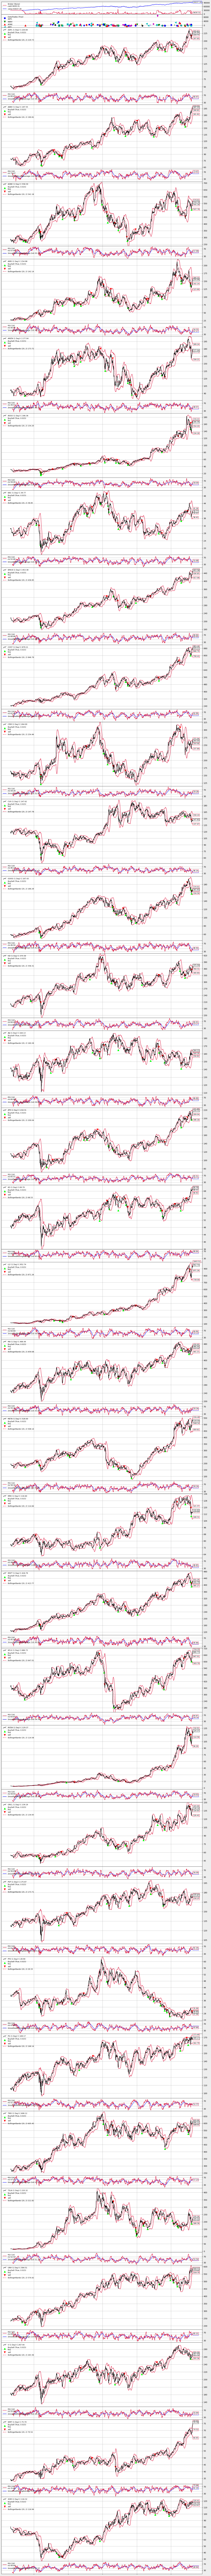

In [1]:
import conf

from strategies.bbrsi_strategy import BbRsiStrategy
from optimise_common import *

import datetime  # For datetime objects
import backtrader as bt
import backtrader.analyzers as btanalyzers
import yfinance as yf

optimise = False
initial_cash = 30000
#initial_cash = 100000

# strategy-controls
printlog=False
print_trade_actions=True
lower_rsi=44 # 44 offered the higher 5-yr profit (150k from 30k initial investment)
loss_pct_threshold = 100 # Effectively full loss tolerance. using values such as 10-11% made little difference
inflection_profit_percentage_target = 5 # 5 showed best outcome for 5 year backtest
fixed_investment_amount=4000 
# backtest window 
num_years = 5
year_offset = 0

# stock to test
tickers = high_performance_stock

warmup_date, start_date, end_date = optimisation_dates(num_years, year_offset)

def pnl_report(strategy):
    total_pnl = 0
    # Unwind any open opositions
    for ticker in strategy.stock_pnl.keys():
        if strategy.getpositionbyname(ticker):
            position = strategy.getpositionbyname(ticker)
            data = strategy.getdatabyname(ticker)
            open_pnl = ((position.size * data.close[0])-(position.size*position.price))
            #print(f'{ticker} open PNL: {position.size:2f} x {data.close[0]:2f} - {position.size:2f} x {position.price:2f} = {open_pnl:2f}')
            strategy.stock_pnl[ticker] += open_pnl
    for ticker in strategy.stock_pnl.keys():
        print(f'{ticker} PNL: {strategy.stock_pnl[ticker]:.2f}')
        total_pnl += strategy.stock_pnl[ticker]
    print(f'Total PNL: {total_pnl:.2f}')

def strategy_completed_callback(strategy):
    final_value = strategy.broker.get_value()
    print("strategy_completed_callback stats: " + 
        f'lower_rsi: {strategy.params.lower_rsi}, ' +
        f'fixed_investment_amount: {strategy.params.fixed_investment_amount}, ' +
        f'inflection_profit_percentage_target: {strategy.params.inflection_profit_percentage_target}, ' +
        f'bb_low_crossover_loss_tolerance: {strategy.params.bb_low_crossover_loss_tolerance}, ' +
        
        f'final_portolio_value: {final_value:.0f}'
    )
    stats.append({'lower_rsi': strategy.params.lower_rsi, 
        'fixed_investment_amount': strategy.params.fixed_investment_amount,
        'inflection_profit_percentage_target': strategy.params.inflection_profit_percentage_target,
        'bb_low_crossover_loss_tolerance': strategy.params.bb_low_crossover_loss_tolerance,
        'final_portolio_value': round(strategy.broker.getvalue())}) 

stats = []

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = create_cerebro()

    if not optimise:
        # Add a strategy (see strategy-controls)
        cerebro.addstrategy(BbRsiStrategy,
                            start_date = start_date,
                            printlog = printlog,
                            print_trade_actions = print_trade_actions,
                            lower_rsi = lower_rsi,
                            loss_pct_threshold = loss_pct_threshold,
                            fixed_investment_amount = fixed_investment_amount,
                            inflection_profit_percentage_target = inflection_profit_percentage_target,
                            custom_callback=pnl_report)
    else:
        strats = cerebro.optstrategy(
            BbRsiStrategy,
            start_date = start_date,
            lower_rsi = 44, # range(42, 45, 1), #, 44 (5-year best)
            inflection_profit_percentage_target = 5, #[2,3,4,5,6,7], # 5 (5-year best)
            bb_low_crossover_loss_tolerance = range(0,11),
            fixed_investment_amount = range(3000, 6000, 500), # 4000 (5-year best)
            custom_callback=strategy_completed_callback,
            )
        cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')

    add_data_feed(cerebro, tickers, warmup_date, start_date, end_date)
    set_cash(cerebro, initial_cash)
    
    execute_cerebro(cerebro, optimise, stats)

    
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams #Creates parameters for our plot
if not optimise:
    print(f'Plotting graphs ...')
    # Plot the result
    rcParams['figure.figsize'] = 16, 6 * len(tickers) #size
    rcParams['figure.facecolor'] = '#eeeeee' #Color scheme
    plt.plot() #The Plot Code
    plt.close()
    cerebro.plot(iplot=True, volume=False)
 